In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [2]:
import shap
import xgboost

/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

## Data sets

In [3]:
adult = pd.read_csv("../datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
print("Adult Shape:", adult.shape)
adult.head(5)

Adult Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
adult.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [4]:
adult_small = adult.sample(1000)
print(adult_small.shape)

(1000, 15)


In [5]:
dataset = adult
#y = y.replace(["yes","no"],[1,0])
#X = pd.get_dummies(X)
oe = OrdinalEncoder()
data = oe.fit_transform(dataset)
encoded = pd.DataFrame(data = data, columns = dataset.columns)
X = encoded.loc[:,'age':'native-country']
y = encoded.loc[:,'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
xgb_model = xgboost.XGBClassifier().fit(X_train, y_train)

y_pred = dt_model.predict(X_test)  
print("Decision Tree")
print(classification_report(y_test,y_pred))
y_pred = xgb_model.predict(X_test)  
print("XGBoost")
print(classification_report(y_test,y_pred))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      2457
         1.0       0.78      0.54      0.64       800

    accuracy                           0.85      3257
   macro avg       0.82      0.74      0.77      3257
weighted avg       0.84      0.85      0.84      3257

XGBoost
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      2457
         1.0       0.79      0.66      0.72       800

    accuracy                           0.87      3257
   macro avg       0.84      0.80      0.82      3257
weighted avg       0.87      0.87      0.87      3257



### Shapley Values

Suppose thay we have three players: A, B, and C. They will play a cooperative game and will obtain a certain gain. Players' individual contribution might be different. We want to calculate the marginal conributions of each player in order to distribute the gain according to their marginal contributions. How can we do it?

The basic idea is to find the marginal contribution of a player, say A, according to the gains in games where A is present and where A is not.



Shapley value:

$$
\phi_i(v) = \sum_{\substack{S \subseteq N \backslash \{i\} }} \frac{(n - |S| - 1)! \cdot (|S|)!}{n!} \left( v(S \cup \{i\}) - v(S) \right) 
$$

where:
- $ \phi_i(v) $ represents the Shapley value of player \( i \) in the game \( v \),
- $ N $ is the set of all players,
- $ S $ is a coalition of players,
- $ n $ is the total number of players, and
- $ v(S) $ denotes the worth of coalition $S$.



In [6]:
import math
import itertools

def calculate_shapley_value(player, player_list, characteristic_function):
    n = len(player_list)
    shapley_value = 0

    for permutation in itertools.permutations(player_list):
        print("Order:", permutation)
        coalition = []
        coalition_value = 0

        for p in permutation:
            if p == player:
                break
            else:
                coalition.append(p)
                
        coalition_value = characteristic_function(coalition)
        coalition.append(player)
        coalition_value_with_player = characteristic_function(coalition)

        marginal_contribution = coalition_value_with_player - coalition_value
        print("Marginal contribution of ", player, ": ",marginal_contribution)
        shapley_value += marginal_contribution / math.factorial(n)

    return shapley_value

# Example characteristic function
def characteristic_function(coalition):
    # Define the characteristic function here
    if len(coalition) == 0:
        return 0
    elif len(coalition) == 1:
        player = coalition[0]
        if player == 'A':
            return 100
        elif player == 'B':
            return 125
        elif player == 'C':
            return 50
    elif len(coalition) == 2:
        if 'A' in coalition and 'B' in coalition:
            return 270
        elif 'A' in coalition and 'C' in coalition:
            return 375
        elif 'B' in coalition and 'C' in coalition:
            return 350
    elif len(coalition) == 3:
        return 500

# Player list
player_list = ['A', 'B', 'C']

# Calculate Shapley values for each player
shapley_values = {}
for player in player_list:
    shapley_values[player] = calculate_shapley_value(player, player_list, characteristic_function)

# Print the Shapley values
for player, value in shapley_values.items():
    print(f"The Shapley value for player {player} is: {value}")


Order: ('A', 'B', 'C')
Marginal contribution of  A :  100
Order: ('A', 'C', 'B')
Marginal contribution of  A :  100
Order: ('B', 'A', 'C')
Marginal contribution of  A :  145
Order: ('B', 'C', 'A')
Marginal contribution of  A :  150
Order: ('C', 'A', 'B')
Marginal contribution of  A :  325
Order: ('C', 'B', 'A')
Marginal contribution of  A :  150
Order: ('A', 'B', 'C')
Marginal contribution of  B :  170
Order: ('A', 'C', 'B')
Marginal contribution of  B :  125
Order: ('B', 'A', 'C')
Marginal contribution of  B :  125
Order: ('B', 'C', 'A')
Marginal contribution of  B :  125
Order: ('C', 'A', 'B')
Marginal contribution of  B :  125
Order: ('C', 'B', 'A')
Marginal contribution of  B :  300
Order: ('A', 'B', 'C')
Marginal contribution of  C :  230
Order: ('A', 'C', 'B')
Marginal contribution of  C :  275
Order: ('B', 'A', 'C')
Marginal contribution of  C :  230
Order: ('B', 'C', 'A')
Marginal contribution of  C :  225
Order: ('C', 'A', 'B')
Marginal contribution of  C :  50
Order: ('C', 'B

### Global, cohort, and local model explainability.

### Shapley value calculation from scratch with sampling

The following code makes a local explanation. The algorithm is as follows:

To calculate the Shapley value for the feature $f_j$ in the prediction for instance $i$:

- for m = 1 to M do:
    - Sample a random subset of features $S_f$ such that $f_j \not\in S_f$.
    - Calculate the marginal contribution of $f_j$ by finding the difference between the prediction with features $S_f + f_j$ and features $S_f$.
    
The average marginal contribution will give the shapely value. This is not exact calculation but will approximate it. One problem is how to make a prediction with only a subset of the features since the model is built with all the features. Building different models for all feature subsets is infeasible. One solution is to use values for the missing features from a randomly choosen instance. The idea is when we do this many times the overall effect of the randomly chosen values will cancel out and in the long run the contribution of $f_j$ for the instance $x$ will emerge.



In [7]:
def shapley_value_by_sampling(model, X, instance_idx, feature_idx, n_iters = 1000):
    
    marginal_contributions = []

    n_features = X.shape[1]
    feature_idxs = list(range(n_features))
    x = X.iloc[instance_idx]
    feature_idxs.remove(feature_idx)

    for _ in range(n_iters):
        r = X.sample(1).values[0]

        # sample S_f
        S_f = random.sample(feature_idxs, random.randint(0,n_features-1))

        x_with_feature = np.array([x[i] if i in S_f + [feature_idx] else r[i] for i in range(n_features)]).reshape(1, -1)
        x_with_feature = pd.DataFrame(x_with_feature, columns=X.columns)
        x_without_feature = np.array([x[i] if i in S_f else r[i] for i in range(n_features)]).reshape(1, -1)
        x_without_feature = pd.DataFrame(x_without_feature, columns=X.columns)

        
        marginal_contribution = model.predict_proba(x_with_feature)[0][1] - model.predict_proba(x_without_feature)[0][1]
        marginal_contributions.append(marginal_contribution)
        
    shapley_value = sum(marginal_contributions) / len(marginal_contributions)  
    return X.columns[feature_idx], shapley_value


In [15]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [17]:
shapley_value_by_sampling(dt_model, X, 10, 10)

('capital-gain', -0.03044336909028209)

In [26]:
shapley_value_by_sampling(xgb_model, X, 10, 7)

('relationship', 0.10034449281753087)

In [22]:
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)
# get just the explanations for the positive class
#shap_values = shap_values[...,1]

 99%|===================| 32329/32561 [01:25<00:00]        

In [22]:
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,1]

Exact explainer: 101it [00:22,  2.71it/s]                         


### Global Explanations

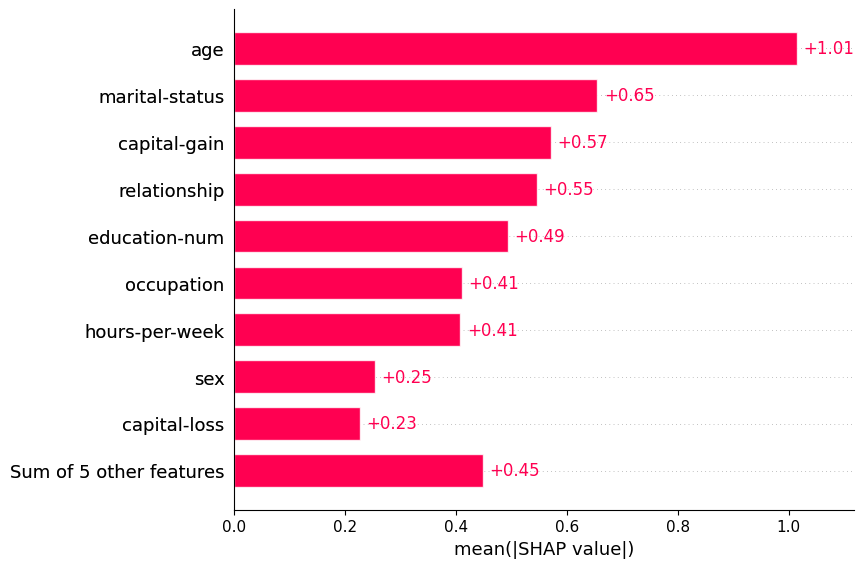

In [23]:
shap.plots.bar(shap_values);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


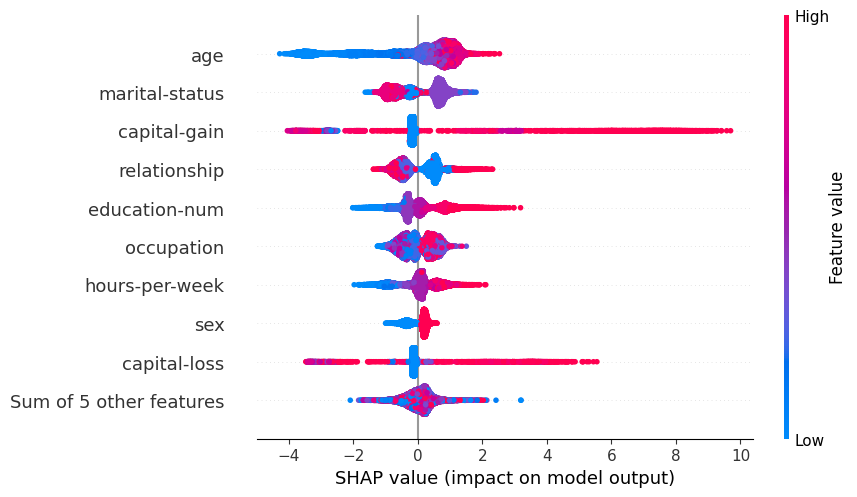

In [24]:
shap.plots.beeswarm(shap_values)

In [48]:
np.unique(adult.relationship.values)

array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
       'Unmarried', 'Wife'], dtype=object)

### Local Explanations

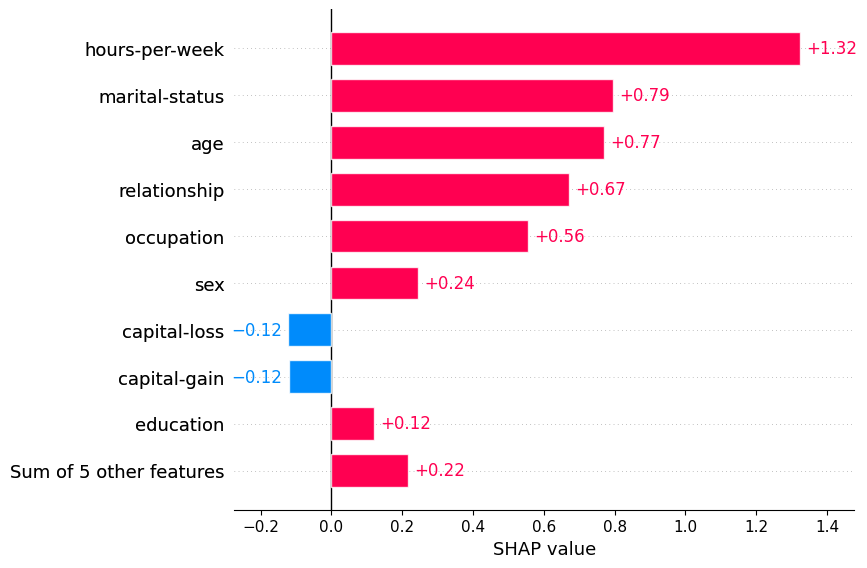

In [25]:
shap.plots.bar(shap_values[10]);